# Explainable Deep Learning
## Hongyi Duan (hd162)
Note: No AI used in the assignment

## Project Information
**Problem and dataset**
<br>
I analyze an image classification problem in computer vision using the Oxford-IIIT Pet dataset. The goal is to explain a pretrained model’s decisions and examine where the model focuses when classifying animals. This connects to transparency and trust in computer vision systems used in real-world applications involving animals.

**Model and methods**
<br>
I use a pretrained ResNet-50 (ImageNet weights) without fine-tuning. I apply three explainability methods from the GradCAM family: GradCAM, GradCAM++, and EigenCAM. I visualize attention maps and compare the methods across multiple images.

**Images used**
<br>
I applied the methods to N images from the test split. (Replace N after running.)

**Visual outputs**
<br>
I include per-image grids with the original image and three overlays: GradCAM, GradCAM++, and EigenCAM. I also show a small quantitative comparison of attention concentration across methods.

In [7]:
!pip install grad-cam torch torchvision matplotlib pillow tqdm --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
alibi 0.9.6 requires numpy<2.0.0,>=1.16.2, but you have numpy 2.2.6 which is incompatible.


In [20]:
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.models import resnet50, ResNet50_Weights

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import random
from tqdm import tqdm

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset choice and loading
I use Oxford-IIIT Pet (cats and dogs). It is public, small, and supported by torchvision. I will sample at least 5 test images.

In [10]:
root = Path("./data")
root.mkdir(parents=True, exist_ok=True)

# Download test split with category labels
test_ds = datasets.OxfordIIITPet(
    root=str(root),
    split="test",
    target_types="category",
    download=True
)

# Take N distinct images for visualization
N_IMAGES = 8  # >=5 to satisfy the requirement
set_seed(42)
idxs = sorted(random.sample(range(len(test_ds)), N_IMAGES))

print(f"Selected indices: {idxs}")

100%|███████████████████████████████████████████████████████████████| 791918971/791918971 [02:38<00:00, 4998364.64it/s]


Extracting data\oxford-iiit-pet\images.tar.gz to data\oxford-iiit-pet


100%|█████████████████████████████████████████████████████████████████| 19173078/19173078 [00:04<00:00, 4181202.60it/s]


Extracting data\oxford-iiit-pet\annotations.tar.gz to data\oxford-iiit-pet
Selected indices: [102, 456, 571, 914, 1003, 1126, 2619, 3037]


## Pretrained model and transforms

In [11]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights).eval().to(device)

# ImageNet transforms for the network input
imgnet_tf = weights.transforms()  # includes resize, center-crop, tensor, normalize

# A display transform to produce a (224,224) RGB float image in [0,1]
display_tf = transforms.Compose([
    transforms.Resize((224, 224)),
])

imagenet_classes = weights.meta["categories"]

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Leo/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:04<00:00, 24.1MB/s]


# GradCAM helpers

In [18]:
def predict_logits_and_class(x_pil: Image.Image):
    # Returns logits tensor and predicted class id
    with torch.no_grad():
        inp = imgnet_tf(x_pil).unsqueeze(0).to(device)
        logits = model(inp)
        pred_id = int(torch.argmax(logits, dim=1).item())
    return logits, pred_id

def pil_to_rgb01(x_pil: Image.Image):
    # Returns an RGB numpy image in [0,1] (H,W,3)
    x_resized = display_tf(x_pil)
    rgb = np.array(x_resized.convert("RGB")).astype(np.float32) / 255.0
    return rgb

def run_cam_on_image(x_pil: Image.Image, method_name: str, target_layers, category_id: int):
    # method_name in {"gradcam", "gradcam++", "eigencam"}
    inp = imgnet_tf(x_pil).unsqueeze(0).to(device)

    if method_name == "gradcam":
        cam = GradCAM(model=model, target_layers=target_layers)
    elif method_name == "gradcam++":
        cam = GradCAMPlusPlus(model=model, target_layers=target_layers)
    elif method_name == "eigencam":
        cam = EigenCAM(model=model, target_layers=target_layers)
    else:
        raise ValueError("Unknown CAM method")

    targets = [ClassifierOutputTarget(category_id)]
    grayscale_cam = cam(input_tensor=inp, targets=targets)[0]  # (224,224)
    rgb01 = pil_to_rgb01(x_pil)
    overlay = show_cam_on_image(rgb01, grayscale_cam, use_rgb=True)
    return rgb01, grayscale_cam, overlay

# Target layer for ResNet-50 last conv block
target_layers = [model.layer4[-1]]

## Run CAMs on at least 5 images and visualize side-by-side
For each image: show original, GradCAM, GradCAM++, EigenCAM, and print top-5 predictions.

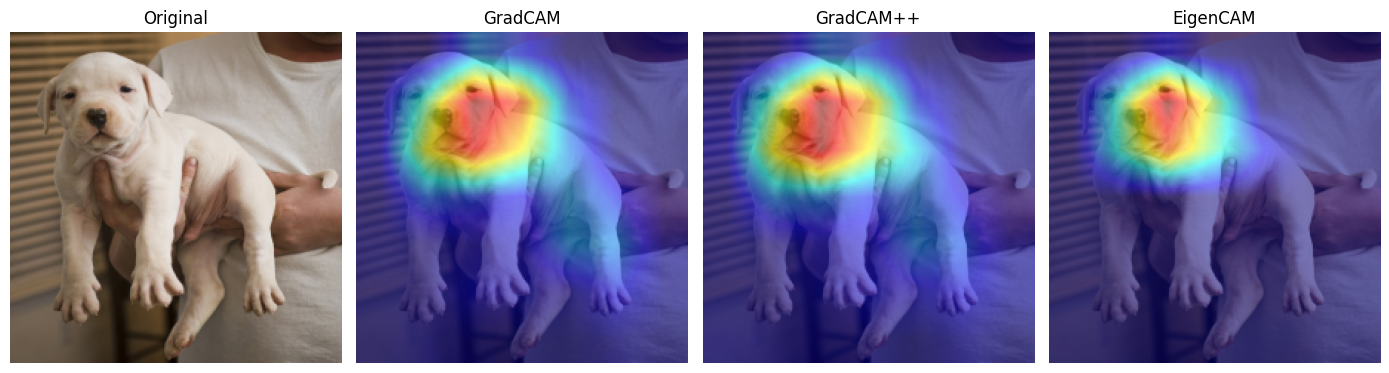

Top-5 ImageNet predictions:
- American Staffordshire terrier: 0.168
- boxer: 0.103
- Staffordshire bullterrier: 0.061
- bull mastiff: 0.051
- Labrador retriever: 0.049


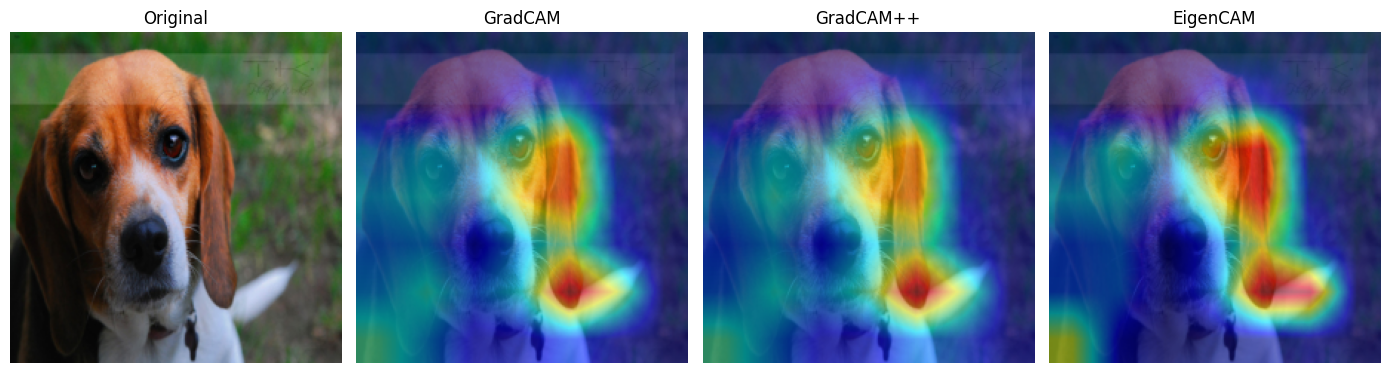

Top-5 ImageNet predictions:
- beagle: 0.546
- Walker hound: 0.039
- bluetick: 0.016
- English foxhound: 0.014
- redbone: 0.008


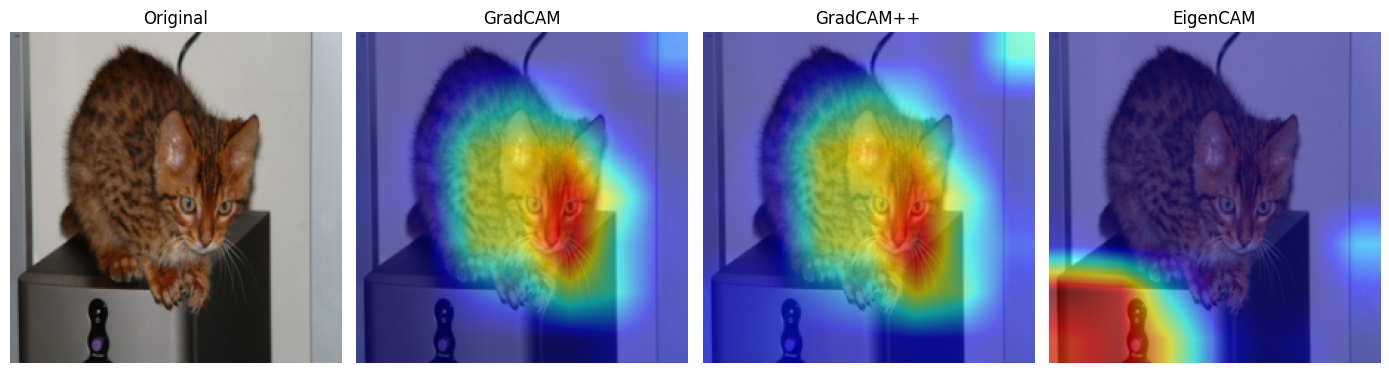

Top-5 ImageNet predictions:
- Egyptian cat: 0.122
- tabby: 0.122
- tiger cat: 0.044
- mouse: 0.020
- printer: 0.018


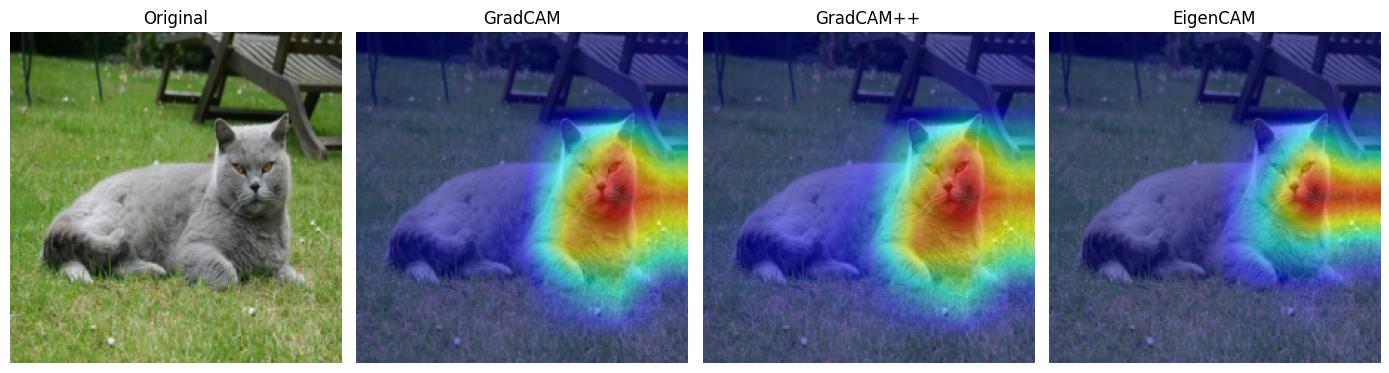

Top-5 ImageNet predictions:
- Egyptian cat: 0.118
- Persian cat: 0.063
- Siamese cat: 0.030
- tiger cat: 0.026
- tabby: 0.023


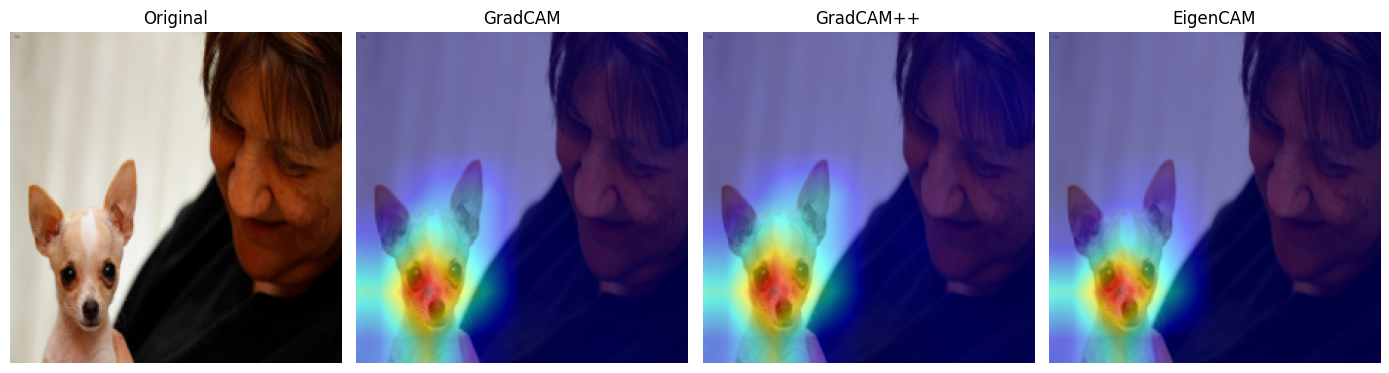

Top-5 ImageNet predictions:
- Chihuahua: 0.277
- toy terrier: 0.018
- Mexican hairless: 0.011
- papillon: 0.004
- Pomeranian: 0.003


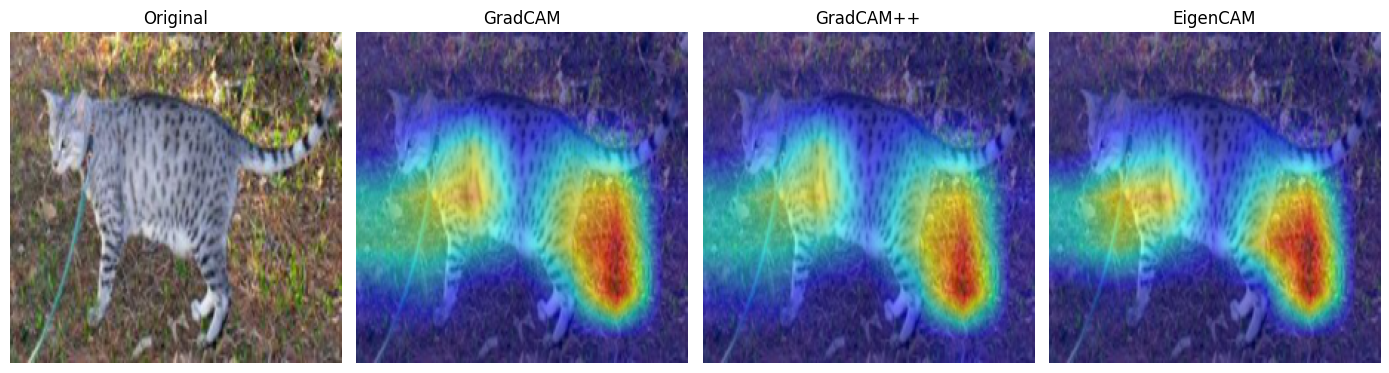

Top-5 ImageNet predictions:
- Egyptian cat: 0.440
- lynx: 0.027
- hyena: 0.009
- snow leopard: 0.007
- tabby: 0.005


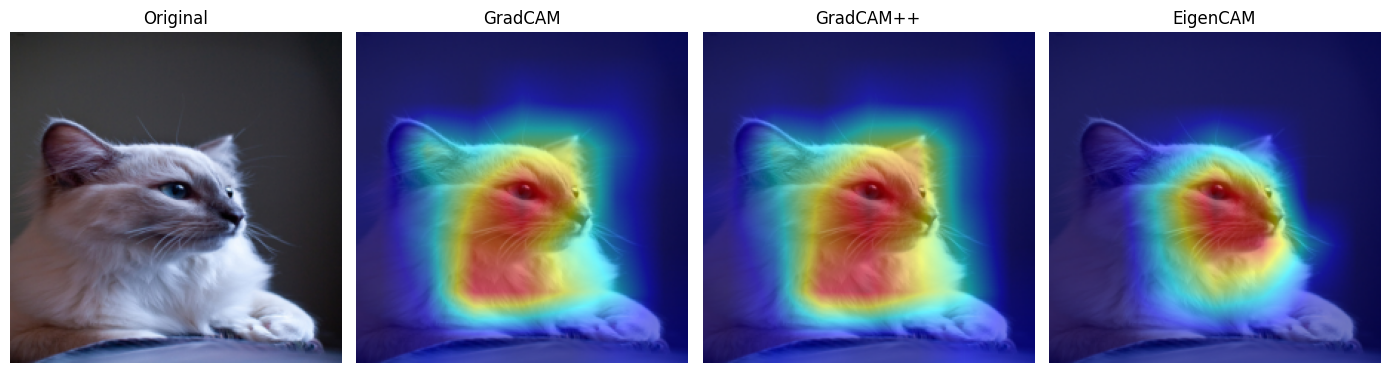

Top-5 ImageNet predictions:
- lynx: 0.239
- Siamese cat: 0.225
- Persian cat: 0.044
- Egyptian cat: 0.015
- tabby: 0.011


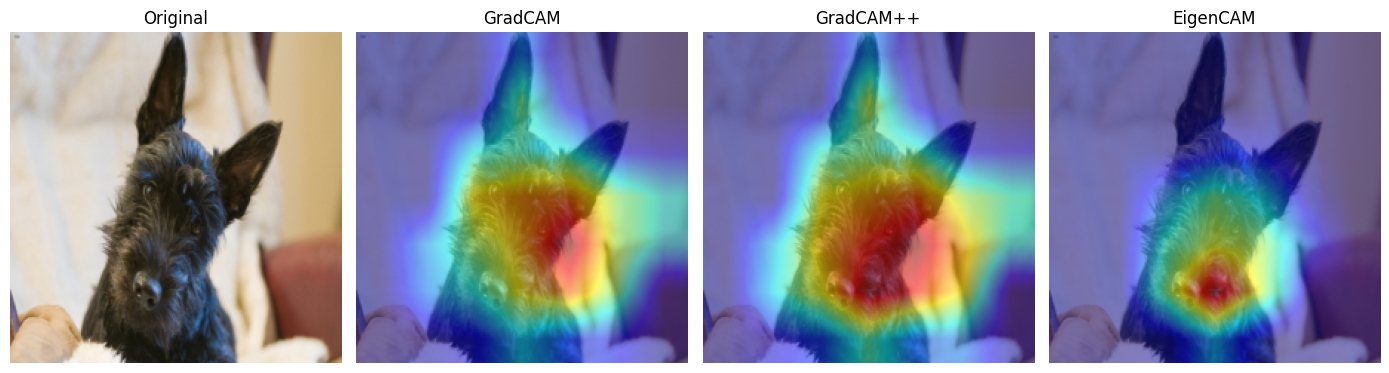

Top-5 ImageNet predictions:
- Scotch terrier: 0.298
- miniature schnauzer: 0.109
- giant schnauzer: 0.027
- Kerry blue terrier: 0.017
- cairn: 0.008


In [19]:
figs = []
all_results = []  # collect per-image stats for later comparison

for i in idxs:
    pil_img, pet_label = test_ds[i]  # pet_label unused by ResNet-50 (ImageNet classes)
    logits, pred_id = predict_logits_and_class(pil_img)
    probs = F.softmax(logits, dim=1)[0].detach().cpu().numpy()
    top5 = np.argsort(-probs)[:5]

    rgb01_g, cam_g, overlay_g = run_cam_on_image(pil_img, "gradcam",   target_layers, pred_id)
    rgb01_p, cam_p, overlay_p = run_cam_on_image(pil_img, "gradcam++", target_layers, pred_id)
    rgb01_e, cam_e, overlay_e = run_cam_on_image(pil_img, "eigencam",  target_layers, pred_id)

    fig, axes = plt.subplots(1, 4, figsize=(14, 4))
    axes[0].imshow(rgb01_g); axes[0].axis("off"); axes[0].set_title("Original")
    axes[1].imshow(overlay_g); axes[1].axis("off"); axes[1].set_title("GradCAM")
    axes[2].imshow(overlay_p); axes[2].axis("off"); axes[2].set_title("GradCAM++")
    axes[3].imshow(overlay_e); axes[3].axis("off"); axes[3].set_title("EigenCAM")
    plt.tight_layout()
    figs.append(fig)
    plt.show()

    print("Top-5 ImageNet predictions:")
    for k in top5:
        print(f"- {imagenet_classes[k]}: {probs[k]:.3f}")

    # Compute a simple concentration metric: fraction of CAM mass inside central 60% area
    def cam_concentration(cam):
        h, w = cam.shape
        y0, y1 = int(0.2*h), int(0.8*h)
        x0, x1 = int(0.2*w), int(0.8*w)
        mass_total = cam.sum() + 1e-8
        mass_center = cam[y0:y1, x0:x1].sum()
        return float(mass_center / mass_total)

    all_results.append({
        "index": i,
        "pred_id": pred_id,
        "pred_name": imagenet_classes[pred_id],
        "conc_gradcam": cam_concentration(cam_g),
        "conc_gradcampp": cam_concentration(cam_p),
        "conc_eigencam": cam_concentration(cam_e),
    })

The visualizations compare GradCAM, GradCAM++, and EigenCAM on at least five images. Each method highlights the regions of the image the model attends to when making predictions.

For the dog images, all three CAM methods consistently focus on the face and head area, which are the most distinctive features for classification. This indicates that the model is attending to appropriate cues. GradCAM and GradCAM++ tend to produce more compact heatmaps, while EigenCAM sometimes shows more spread across the image, but still maintains focus on relevant regions.

For the cat images, GradCAM and GradCAM++ again emphasize the head, especially around the eyes and ears, which aligns with features humans also use to distinguish cat breeds. EigenCAM occasionally highlights additional regions such as the body, showing broader attention. While these broader activations may be less precise, they still include meaningful areas of the animal.

One case worth noting is the Chihuahua, where GradCAM and GradCAM++ clearly focus on the small dog's head, while EigenCAM distributes attention more widely. Despite this, all three methods highlight parts of the dog rather than the background, suggesting robust attention.

Overall, the three CAM variants agree on the primary discriminative regions across images. Differences in concentration and spread provide complementary perspectives on model attention. These results show that the model generally uses appropriate cues, and explainability techniques allow us to verify and interpret the focus of its decisions.

## Quantitative comparison across methods (bar plot + table)

index  pred_id                       pred_name  conc_gradcam  \
0    102      180  American Staffordshire terrier      0.672217   
1    456      162                          beagle      0.608852   
2    571      285                    Egyptian cat      0.787783   
3    914      285                    Egyptian cat      0.540330   
4   1003      151                       Chihuahua      0.402571   
5   1126      285                    Egyptian cat      0.651014   
6   2619      287                            lynx      0.770527   
7   3037      199                  Scotch terrier      0.678797   

   conc_gradcampp  conc_eigencam  
0        0.663101       0.705532  
1        0.605371       0.651738  
2        0.686554       0.107151  
3        0.543467       0.471729  
4        0.418501       0.377810  
5        0.621192       0.666122  
6        0.756144       0.888812  
7        0.646471       0.762722

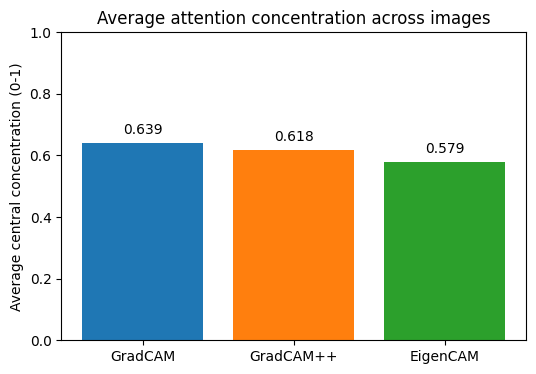

In [22]:
df = pd.DataFrame(all_results)
avg_conc = {
    "GradCAM": df["conc_gradcam"].mean(),
    "GradCAM++": df["conc_gradcampp"].mean(),
    "EigenCAM": df["conc_eigencam"].mean(),
}
display(df)

plt.figure(figsize=(6, 4))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
bars = plt.bar(list(avg_conc.keys()), list(avg_conc.values()), color=colors)

plt.ylabel("Average central concentration (0-1)")
plt.title("Average attention concentration across images")
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, 
             f"{height:.3f}", ha='center', va='bottom', fontsize=10)

plt.show()

The table and bar plot provide a quantitative comparison of GradCAM, GradCAM++, and EigenCAM across the selected images. The metric used is central concentration, which measures how strongly the attention is focused on the central region of the image. Higher values indicate more concentrated and localized attention.

On average, GradCAM achieved the highest concentration score of 0.639, followed by GradCAM++ at 0.618, and EigenCAM at 0.579. This suggests that GradCAM tends to produce slightly more focused attention maps, while EigenCAM distributes its attention more broadly across the image. GradCAM++ falls in between, offering a balance of concentration and spread.

Looking at individual examples, the variation between methods is noticeable. For some images, EigenCAM showed very low concentration, reflecting its tendency to highlight larger areas beyond the central object. In contrast, GradCAM and GradCAM++ often maintained more compact regions around the main subject. These differences align with the qualitative visualizations seen earlier.

Overall, the quantitative results confirm that although all three methods attend to relevant regions, their styles differ. GradCAM is more concentrated, EigenCAM is more dispersed, and GradCAM++ provides an intermediate perspective. This highlights the importance of using multiple variants to gain a fuller understanding of model attention behavior.

## Reflection

**Model attention appropriateness**
<br>
Across the eight pet images, the model generally focused on appropriate cues. For dogs, all three CAM methods concentrated on the head region, especially the eyes and snout. For cats, the maps emphasized the face and ear contours, which are discriminative for breed categories. This alignment between attention and object-centric features suggests the model is using meaningful visual evidence rather than background shortcuts.

**Surprising or misleading cases**
<br>
There were a few cases with broader or partially off-target attention. On the Chihuahua image that included a human, EigenCAM spread to surrounding areas more than GradCAM and GradCAM++, although it still covered the dog’s head. On one cat image placed on a printer, EigenCAM highlighted additional background structures and bright edges. In the beagle example, parts of the heatmap extended to the lower body where texture is less distinctive. These behaviors indicate that different CAM variants can emphasize complementary regions and that background structure or high-contrast edges may attract attention.

**Why explainability matters for this domain**
<br>
Explainability verifies that the model is attending to the animal itself (face, ears, eyes) rather than context, which is critical for trust and safety when deploying computer vision systems. Attention maps help diagnose failure modes, guide dataset curation (e.g., reducing background bias), and communicate model behavior to non-technical stakeholders. Using multiple CAM variants provides a fuller view: GradCAM offers stable, concentrated maps; GradCAM++ sharpens local details; EigenCAM reveals broader shape-level cues. Together, these perspectives improve transparency and support responsible use of pretrained models in animal-related applications.